# Importing Libraries

In [41]:
import pandas as pd
pd.options.display.max_columns = None
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes 
from IPython.display import Image
import utm
from imblearn.over_sampling import SMOTE

# Data Loading & Handling

## Data Loading / Wrangling Pipeline

In [42]:
def data_pipeline(years=[2018,2019,2020,2021]):
    
    ### LOAD ORIGINAL DATA ###
    base_string = r"data\raw_data_Strassenverkehrsunfaelle\AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_XXXX_Datensatz.csv"
    csv_file_path = [base_string.replace("XXXX", str(y)) for y in years]
    
    data_all = pd.DataFrame() # create empty dataframe to append yearly dataframes to 
    
    ### DATA WRANGLING ###
    for csv in csv_file_path:
        df = pd.read_csv(csv, sep=";", encoding = 'latin1')
        
        ### MAKE COLUMNS LOWERCASE ###
        df.columns = [col.lower() for col in df.columns]
        
        ### REPLACE DECIMAL COMMA TO DOT
        df["linrefx"] = list(map(lambda x: x.replace(",", "."), df["linrefx"]))
        df["linrefy"] = list(map(lambda x: x.replace(",", "."), df["linrefy"]))
        df["xgcswgs84"] = list(map(lambda x: x.replace(",", "."), df["xgcswgs84"]))
        df["ygcswgs84"] = list(map(lambda x: x.replace(",", "."), df["ygcswgs84"]))
        
        ### RENAME GCSWGS COLUMNS ###
        if "2018" in csv: # if data from 2018, then rename two columns additionally to match later data
            df.rename(columns={"istsonstig": "istsonstige", "strzustand": "ustrzustand"}, inplace=True)
        df.rename(columns={"xgcswgs84": "long", "ygcswgs84": "lat"}, inplace=True)
        
        ### RENAME / RESORT WEEKDAYS ###
        rename_days = {1: 7, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

        df["uwochentag"] = [rename_days[day] if day in rename_days.keys()
                                  else day
                                  for day in df["uwochentag"]]
        
        ### CREATE GEOMETRY-POINTS FROM LONG/LAT FOR GEOJSON DISPLAYS ###
        geometry = gpd.points_from_xy(df["long"], df["lat"])
        df = gpd.GeoDataFrame(df, geometry=geometry)
        df.crs = "EPSG:4326"
        
        ### COMBINE DFs OF ALL YEARS INTO ONE ###
        data_all = pd.concat([data_all, df], axis=0)
        data_all.reset_index(drop=True, inplace=True)

    ### MAKE DF LEAN -> DROP ALL UNNECESSARY COLUMNS ###
    data_all_lean = data_all[['bez', 'ujahr', 'umonat', 'ustunde', 'uwochentag', 
                         'ukategorie', 'uart', 'utyp1', 'ulichtverh', 
                         'istrad', 'istpkw', 'istfuss', 'istkrad', 'istgkfz',
                         'istsonstige', 'ustrzustand', 'geometry']]
    
    return data_all, data_all_lean

data_all, data_all_lean = data_pipeline()
data18, data18_lean = data_pipeline(["2018"])
data19, data19_lean = data_pipeline(["2019"])
data20, data20_lean = data_pipeline(["2020"])
data21, data21_lean = data_pipeline(["2021"])

## Save Dataframe to csv

## Load Original Data

## Make Columns Lowercase

## Replace decimal marker (comma -> dot)

## Rename `_gcswgs84` columns

# Explanations

# Initial EDA

## Checking NaN distribution in features in `data_all`

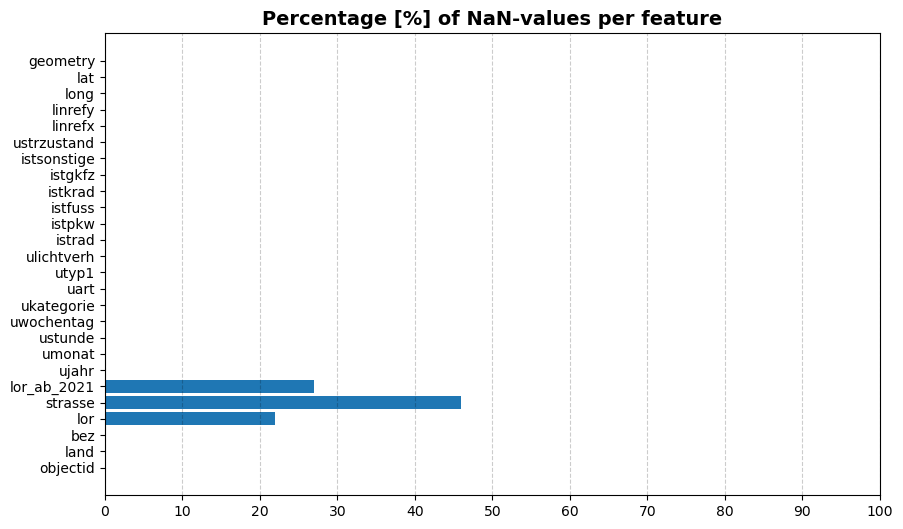

In [43]:
feature_nan_perc = [int(round((data_all[col].isna().sum() / len(data_all[col])*100),0)) 
                    for col in list(data_all.columns)]

fig, ax = plt.subplots(figsize=(10,6))
plt.title("Percentage [%] of NaN-values per feature", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(data_all.columns, feature_nan_perc)
plt.xticks(np.arange(0,101,10))

plt.show()

## Explore data21

### Check feature uniques

- accidents by:
    - type / kind / category
    - borough
    - month / day / time

In [44]:
data21

,objectid,land,bez,lor_ab_2021,ujahr,umonat,ustunde,uwochentag,ukategorie,uart,utyp1,ulichtverh,istrad,istpkw,istfuss,istkrad,istgkfz,istsonstige,ustrzustand,linrefx,linrefy,long,lat,geometry
0,219249,11,3,3701658.0,2021,11,18,1,3,0,3,2,0,1,0,1,0,0,1,800202.0742,5829640.204,13.42689483,52.53393955,POINT (13.42689 52.53394)
1,219248,11,7,7501134.0,2021,12,19,6,3,6,2,2,0,1,1,0,0,0,1,798479.5317,5819049.219,13.39209027,52.43995086,POINT (13.39209 52.43995)
2,219247,11,4,4100101.0,2021,12,17,3,3,5,2,2,0,1,0,0,0,0,0,793352.6128,5829680.195,13.32624193,52.53802784,POINT (13.32624 52.53803)
3,219246,11,4,4501041.0,2021,12,15,6,3,5,2,1,0,1,0,1,0,0,1,792950.0395,5825362.081,13.31652064,52.49953417,POINT (13.31652 52.49953)
4,219243,11,11,11501339.0,2021,12,9,4,3,3,6,0,0,1,0,0,0,1,2,807182.01,5825602.793,13.52575163,52.49386714,POINT (13.52575 52.49387)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,112174,11,4,4300414.0,2021,3,16,3,3,6,2,0,0,1,1,0,0,0,1,791505.4105,5826555.664,13.29634478,52.51100814,POINT (13.29634 52.51101)
11263,111541,11,4,4400726.0,2021,1,1,5,3,9,1,2,0,1,0,0,0,0,0,791154.679,5824616.757,13.28949592,52.49381321,POINT (13.28950 52.49381)
11264,110370,11,3,2400520.0,2021,1,20,7,3,3,6,2,0,1,0,0,0,0,1,799988.2122,5828912.431,13.42309463,52.52753402,POINT (13.42309 52.52753)
11265,109998,11,7,7300619.0,2021,1,14,6,3,2,6,0,0,1,0,0,0,0,1,796018.2589,5822739.196,13.35925879,52.47436651,POINT (13.35926 52.47437)


In [45]:
#1 - "Mitte"
#2 - "Friedrichshain-Kreuzberg"
#3 - "Pankow"
#4 - "Charlottenburg-Wilmersdorf
#5 - "Spandau"
#6 - "Steglitz-Zehlendorf"
#7 - "Tempelhof-Schöneberg"
#8 - "Neukölln
#9 - "Treptow-Köpenick"
#10 - "Marzahn-Hellersdorf"
#11 - "Lichtenberg"
#12 - "Reinickendorf"

data21["bez"].value_counts().sort_index()

1     1761
2     1107
3     1011
4     1398
5      713
6      757
7     1059
8      799
9      776
10     538
11     619
12     729
Name: bez, dtype: int64

In [46]:
data21["umonat"].value_counts().sort_index()

1      481
2      436
3      765
4      720
5      991
6     1314
7     1053
8     1274
9     1300
10    1130
11    1007
12     796
Name: umonat, dtype: int64

In [47]:
#1 = Sonntag
#2 = Montag
#3 = Dienstag
#4 = Mittwoch
#5 = Donnerstag
#6 = Freitag
#7 = Samstag

data21["uwochentag"].value_counts().sort_index()

1    1786
2    1941
3    1868
4    1792
5    1781
6    1207
7     892
Name: uwochentag, dtype: int64

In [48]:
data21["ustunde"].value_counts().sort_index()

0      104
1       80
2       58
3       50
4       56
5      115
6      258
7      504
8      580
9      560
10     584
11     639
12     715
13     763
14     895
15    1031
16     951
17     915
18     788
19     572
20     379
21     276
22     229
23     165
Name: ustunde, dtype: int64

In [49]:
#1 = Unfall mit Getöteten // Accident with death
#2 = Unfall mit Schwerverletzten // Accident with severely injured 
#3 = Unfall mit Leichtverletzten // Accident with slightly injured

data21["ukategorie"].value_counts().sort_index()

1      31
2    1654
3    9582
Name: ukategorie, dtype: int64

In [50]:
#1 = Zusammenstoß mit anfahrendem/anhaltendem/ruhendem Fahrzeug // 
#2 = Zusammenstoß mit vorausfahrendem/wartendem Fahrzeug // 
#3 = Zusammenstoß mit seitlich in gleicher Richtung fahrendem Fahrzeug // 
#4 = Zusammenstoß mit entgegenkommendem Fahrzeug // 
#5 = Zusammenstoß mit einbiegendem/ kreuzendem Fahrzeug // 
#6 = Zusammenstoß zwischen Fahrzeug und Fußgänger // 
#7 = Aufprall auf Fahrbahnhindernis // 
#8 = Abkommen von Fahrbahn nach rechts // 
#9 = Abkommen von Fahrbahn nach links // 
#0 = Unfall anderer Art //

accidents_clusters = {
    "Crash with vehicle" : [1,2,3,4,5],
    "Vehicle-Person Crash" : 6,
    "Other crash" : 0,
    "Accident by Lane Departure" : [8,9],
    "Collision with Road-Object" : 7}

data21["uart"].value_counts().sort_index()

0    1537
1     943
2    2021
3     642
4     151
5    4355
6    1359
7      20
8     126
9     113
Name: uart, dtype: int64

In [51]:
#1 = Fahrunfall // 
#2 = Abbiegeunfall // 
#3 = Einbiegen / Kreuzen-Unfall // 
#4 = Überschreiten-Unfall // 
#5 = Unfall durch ruhenden Verkehr // 
#6 = Unfall im Längsverkehr // 
#7 = sonstiger Unfall // 

data21["utyp1"].value_counts().sort_index()

1     918
2    2764
3    2288
4     781
5     938
6    2449
7    1129
Name: utyp1, dtype: int64

In [52]:
#0 = Tageslicht // daylight
#1 = Dämmerung // twilight
#2 = Dunkelheit // darkness

data21["ulichtverh"].value_counts().sort_index()

0    8472
1     681
2    2114
Name: ulichtverh, dtype: int64

In [53]:
#0 = Unfall ohne Fahrradbeteiligung // Accident without bicycle 
#1 = Unfall mit Fahrradbeteiligung // Accident with bicycle

data21["istrad"].value_counts().sort_index()

0    7016
1    4251
Name: istrad, dtype: int64

In [54]:
#0 = Unfall ohne PKW-Beteiligung // Accident without car
#1 = Unfall mit PKW-Beteiligung // Accident with car

data21["istpkw"].value_counts().sort_index()

0    2229
1    9038
Name: istpkw, dtype: int64

In [55]:
#0 = Unfall ohne Kraftrad // Accident without motorcycle
#1 = Unfall mit Kraftrad // Accident with motorcycle

data21["istkrad"].value_counts().sort_index()

0    9611
1    1656
Name: istkrad, dtype: int64

In [56]:
#0 = Unfall ohne Fußgänger // Accident without pedestrian 
#1 = Unfall mit Fußgänger // Accident with pedestrian

data21["istfuss"].value_counts().sort_index()

0    9807
1    1460
Name: istfuss, dtype: int64

In [57]:
#0 = Unfall ohne LKW // Accident without truck 
#1 = Unfall mit LKW // Accident with truck

data21["istgkfz"].value_counts().sort_index()

0    10925
1      342
Name: istgkfz, dtype: int64

In [58]:
#0 = trocken // dry
#1 = nass/feucht/schlüpfrig // wet/damp/slippery
#2 = winterglatt // winter slipperiness

data21["ustrzustand"].value_counts().sort_index()

0    8407
1    2694
2     166
Name: ustrzustand, dtype: int64

### Accidents per month

In [59]:
month_number_list = sorted(list(data21["umonat"].unique()))
borough_number_list = sorted(list(data21["bez"].unique()))
accidents_per_month = [len(data21[data21["umonat"]==monat]) for monat in month_number_list]
#accidents_per_month = list(data21["umonat"].value_counts().sort_index().values)

month_list = ["January", "February", "March", "April", "May", "June", 
              "July", "August", "September", "October", "November", "December"]

borough_list = ["Mitte", "Friedrichshain-Kreuzberg", "Pankow", "Charlottenburg-Wilmersdorf",
               "Spandau", "Steglitz-Zehlendorf", "Tempelhof-Schöneberg", "Neukölln",
               "Treptow-Köpenick", "Marzahn-Hellersdorf", "Lichtenberg", "Reinickendorf"]

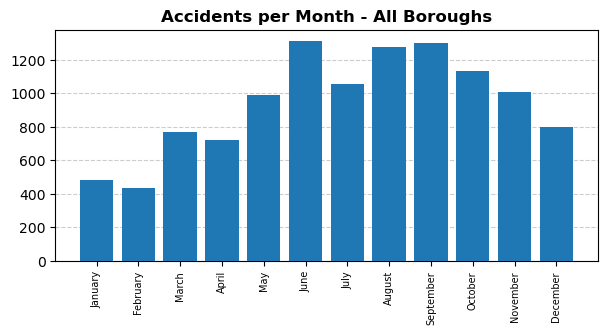

In [60]:
fig, ax = plt.subplots(figsize=(7,3))
plt.title("Accidents per Month - All Boroughs", size=12, weight="bold")
ax.grid(ls="--", color="k", alpha=0.2, axis="y", zorder = 0)
ax.bar(month_number_list, accidents_per_month, zorder = 3)
ax.set_xticks(month_number_list, month_list, rotation = 90, size=7)
plt.show()

### Accidents per borough and month

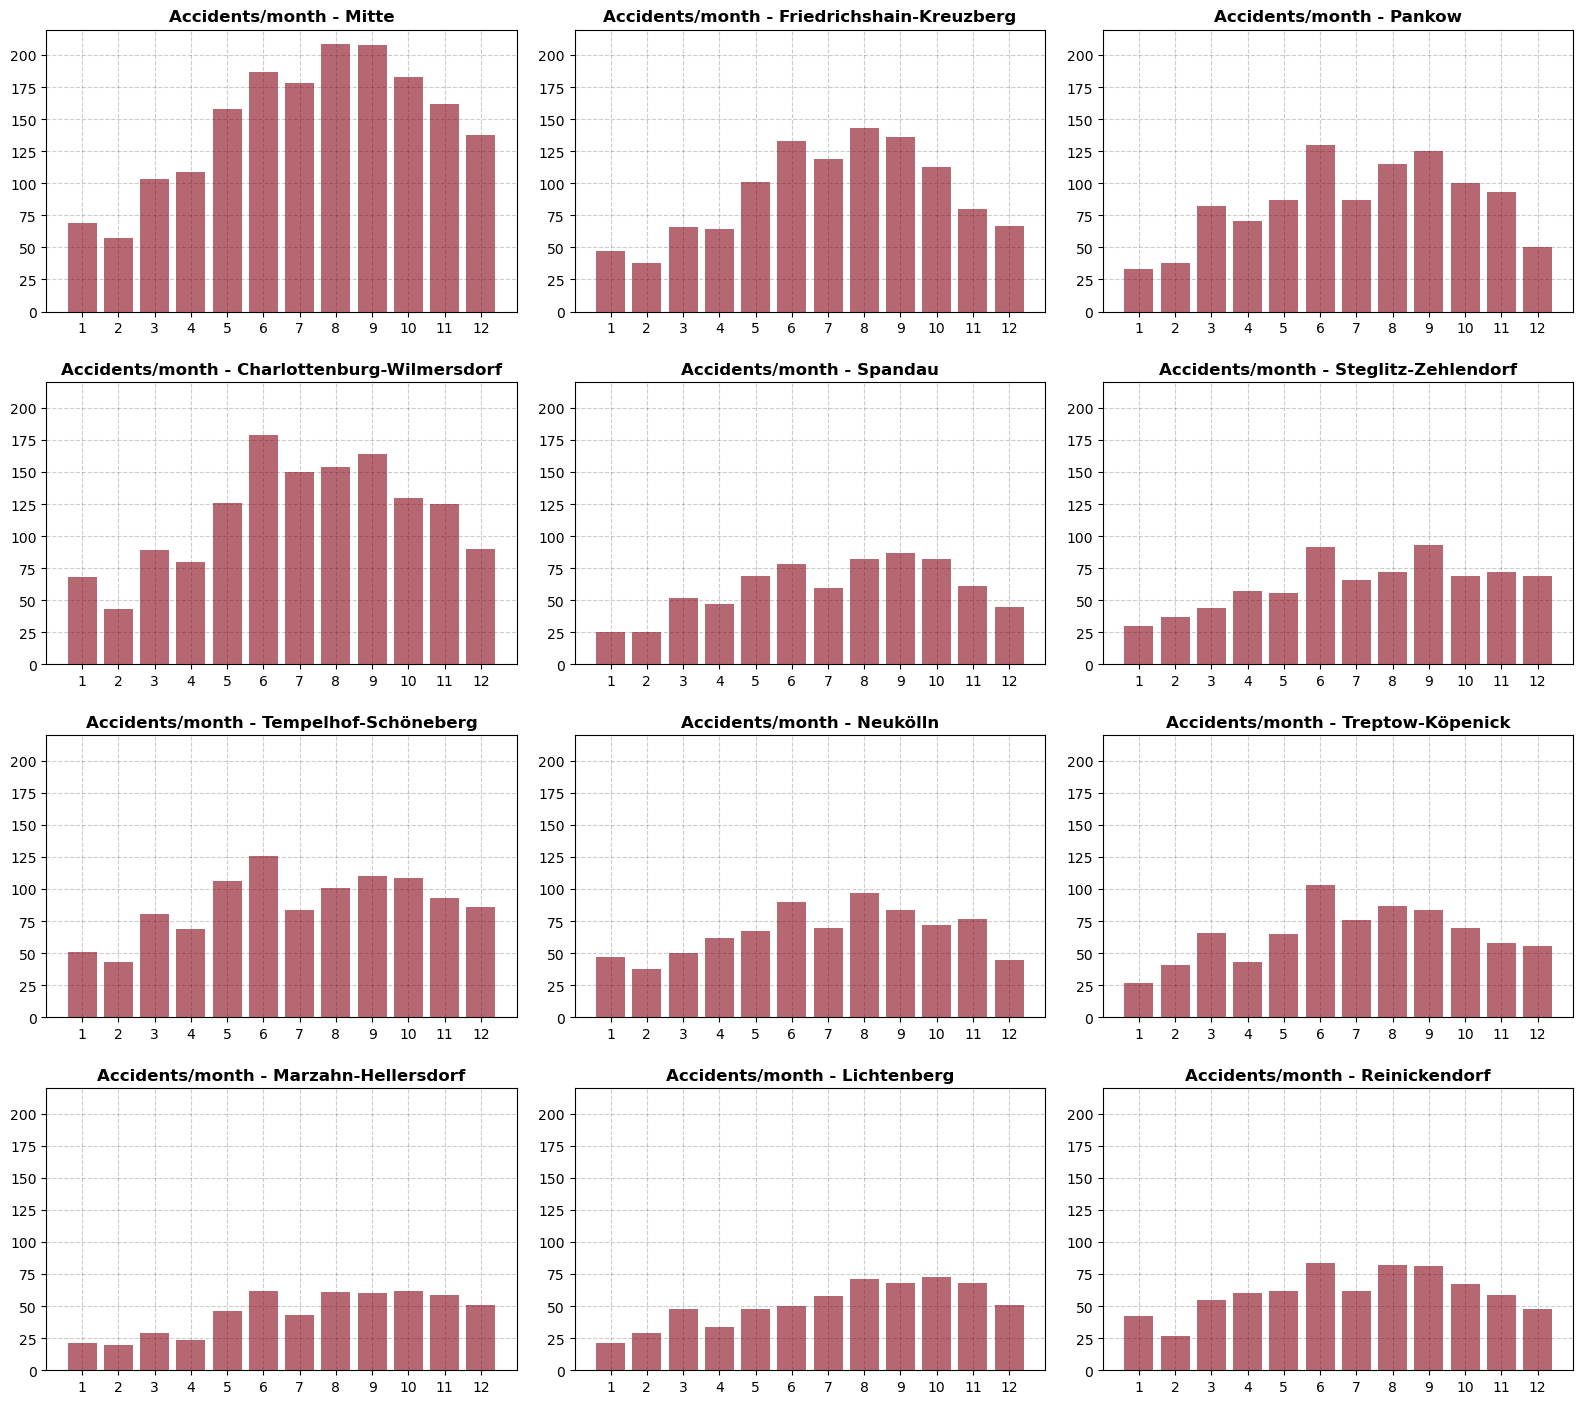

In [61]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3)

for p in range(rows*cols):
    # Customer Lifetime Value
    
    df_borough = data21[data21["bez"]==p+1]
    accidents_per_month = [len(df_borough[df_borough["umonat"]==monat]) for monat in month_number_list]
    
    ax[plot_coords[p]].set_title(f"Accidents/month - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--")
    ax[plot_coords[p]].bar(month_number_list, accidents_per_month, zorder=3, color="#860315", alpha=0.6)
    ax[plot_coords[p]].set_xticks(range(1,13,1))
    ax[plot_coords[p]].set_ylim([0,220])

plt.show()

## Location Data

In [62]:
len(data18.columns), len(data19.columns), len(data20.columns), len(data21.columns)

(26, 25, 25, 24)

# Research Questions

- accidents per hour of day
- more accidents on mondays? ✅
- more accidents on rainy/slippery days? ✅
- more severe accidents on rainy/slippery days?	
	- heavily imbalanced data!?
- check accident counts vs borough population ✅
- more accidents at night?
	- normalize by traffic
- accidents with bicycle per borough
- more severe accidents when motorcycles involved?
- more severe accidents when trucks involved?


**`- train classification model for predicting accident severity`**

## Classification Model for predicting accident severity

**MODELS TO TEST**
- KNN Classifier
- Random Forest
- Logistic Regression

**Improve Models by:**
- Cross Validation (GridSearchCV)
- Hyper Parameter Tuning

**`TO DOs`**
- drop further unnecessary features (land, geometry) ✅
- scaling imbalanced data ✅
    - downsample 3 to 2-lvl
    - upsample 1 to 2-lvl with smote
    OR
    - decide on amount of datapoints (> kat1 but < kat2)
    - scale to that level
- X y split
- test different models (see above)
- improving model performance
- choosing best performing model under given circumstances

### Drop further unnecessary features (land, geometry)

In [63]:
if "ujahr" in data_all_lean.columns:
    data_all_lean.drop(["ujahr", "geometry"], axis=1, inplace=True)
else:
    pass

C:\Users\p.kollhof\AppData\Local\Temp\ipykernel_11260\10045154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all_lean.drop(["ujahr", "geometry"], axis=1, inplace=True)


In [64]:
kat_3 = data_all_lean[data_all_lean["ukategorie"]==3]
kat_2 = data_all_lean[data_all_lean["ukategorie"]==2]
kat_1 = data_all_lean[data_all_lean["ukategorie"]==1]

len(kat_3), len(kat_2), len(kat_1)

(42413, 7554, 151)

### Scaling imbalanced data

#### Downsample kat-3 to lvl-2 & upsample kat-1 to lvl-2

In [65]:
### Downsample kat-3 to lvl-2  ###
kat_3_down_lvl2 = kat_3.sample(len(kat_2))
kat_3_down_lvl2 = kat_3_down_lvl2.sample(frac=1) 

### Upsample kat-1 to lvl-2 with SMOTE ###
kat_1_2 = data_all_lean[data_all_lean["ukategorie"]!=3] # separate kat3
X_kat_1_2, y_kat_1_2 = kat_1_2.drop(["ukategorie"], axis=1), kat_1_2["ukategorie"] # X y split for smote preparation
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_kat_1_2, y_kat_1_2) # resampling kat1 to lvl2
kat_1up_2 = pd.concat([X_sm, y_sm], axis=1) # recombine kat1-upsampled with kat2
kat_3down_1upSmote_lvl2 = pd.concat([kat_1up_2, kat_3_down_lvl2]).reset_index(drop=True) # recombine kat1-upsampled + kat2 with kat3_downsampled

kat_3down_1upSmote_lvl2["ukategorie"].value_counts()

2    7554
1    7554
3    7554
Name: ukategorie, dtype: int64

#### Upsample kat-2 and kat-3 to lvl-1x

In [66]:
### Upsample kat-1 & kat_1 to lvl-3 with SMOTE ###
## Upsample kat-1 to lvl-3 ##
kat_1_tolvl3 = data_all_lean[data_all_lean["ukategorie"]!=2] # only select kat1 & kat3
X_kat_1_tolvl3, y_kat_1_tolvl3 = kat_1_tolvl3.drop(["ukategorie"], axis=1), kat_1_tolvl3["ukategorie"] # X y split for smote preparation
smote = SMOTE()
X_kat_1_tolvl3_sm, y_kat_1_tolvl3_sm = smote.fit_resample(X_kat_1_tolvl3, y_kat_1_tolvl3) # resampling kat1 to lvl3
kat_1up_tolvl3 = pd.concat([X_kat_1_tolvl3_sm, y_kat_1_tolvl3_sm], axis=1) # recombine kat1-upsampled with kat3

## Upsample kat-3 to lvl-1 ##
kat_2_tolvl3 = data_all_lean[data_all_lean["ukategorie"]!=1] # only select kat2 & kat3
X_kat_2_tolvl3, y_kat_2_tolvl3 = kat_2_tolvl3.drop(["ukategorie"], axis=1), kat_2_tolvl3["ukategorie"] # X y split for smote preparation
smote = SMOTE()
X_kat_2_tolvl3_sm, y_kat_2_tolvl3_sm = smote.fit_resample(X_kat_2_tolvl3, y_kat_2_tolvl3) # resampling kat2 to lvl3
kat_2up_tolvl3 = pd.concat([X_kat_2_tolvl3_sm, y_kat_2_tolvl3_sm], axis=1) # recombine kat2-upsampled with kat3

## Combine the two upsampled dataframe ##
kat_1upsmote_2upsmote_lvl3 = pd.concat([kat_1up_tolvl3, kat_2up_tolvl3[kat_2up_tolvl3["ukategorie"]==2]], axis=0).reset_index(drop=True)

In [67]:
display(kat_1up_tolvl3["ukategorie"].value_counts())
display(kat_2up_tolvl3["ukategorie"].value_counts())
kat_1upsmote_2upsmote_lvl3["ukategorie"].value_counts()

3    42413
1    42413
Name: ukategorie, dtype: int64

3    42413
2    42413
Name: ukategorie, dtype: int64

3    42413
1    42413
2    42413
Name: ukategorie, dtype: int64

#### Up-/Downsample all to predetermined level

### X y Split

#### Down-/Upsampled data

In [68]:
X_kat_3down_1upsmote_lvl2 = kat_3down_1upSmote_lvl2.drop(["ukategorie"], axis=1)
y_kat_3down_1upsmote_lvl2 = kat_3down_1upSmote_lvl2["ukategorie"]

#### Upsampled (smote) data

In [69]:
X_kat_1upsmote_2upsmote_lvl3 = kat_1upsmote_2upsmote_lvl3.drop(["ukategorie"], axis=1)
y_kat_1upsmote_2upsmote_lvl3 = kat_1upsmote_2upsmote_lvl3["ukategorie"]

## More accidents on mondays?

In [70]:
weekdays_num = sorted(data_all["uwochentag"].unique())
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

### Accidents per day and borough

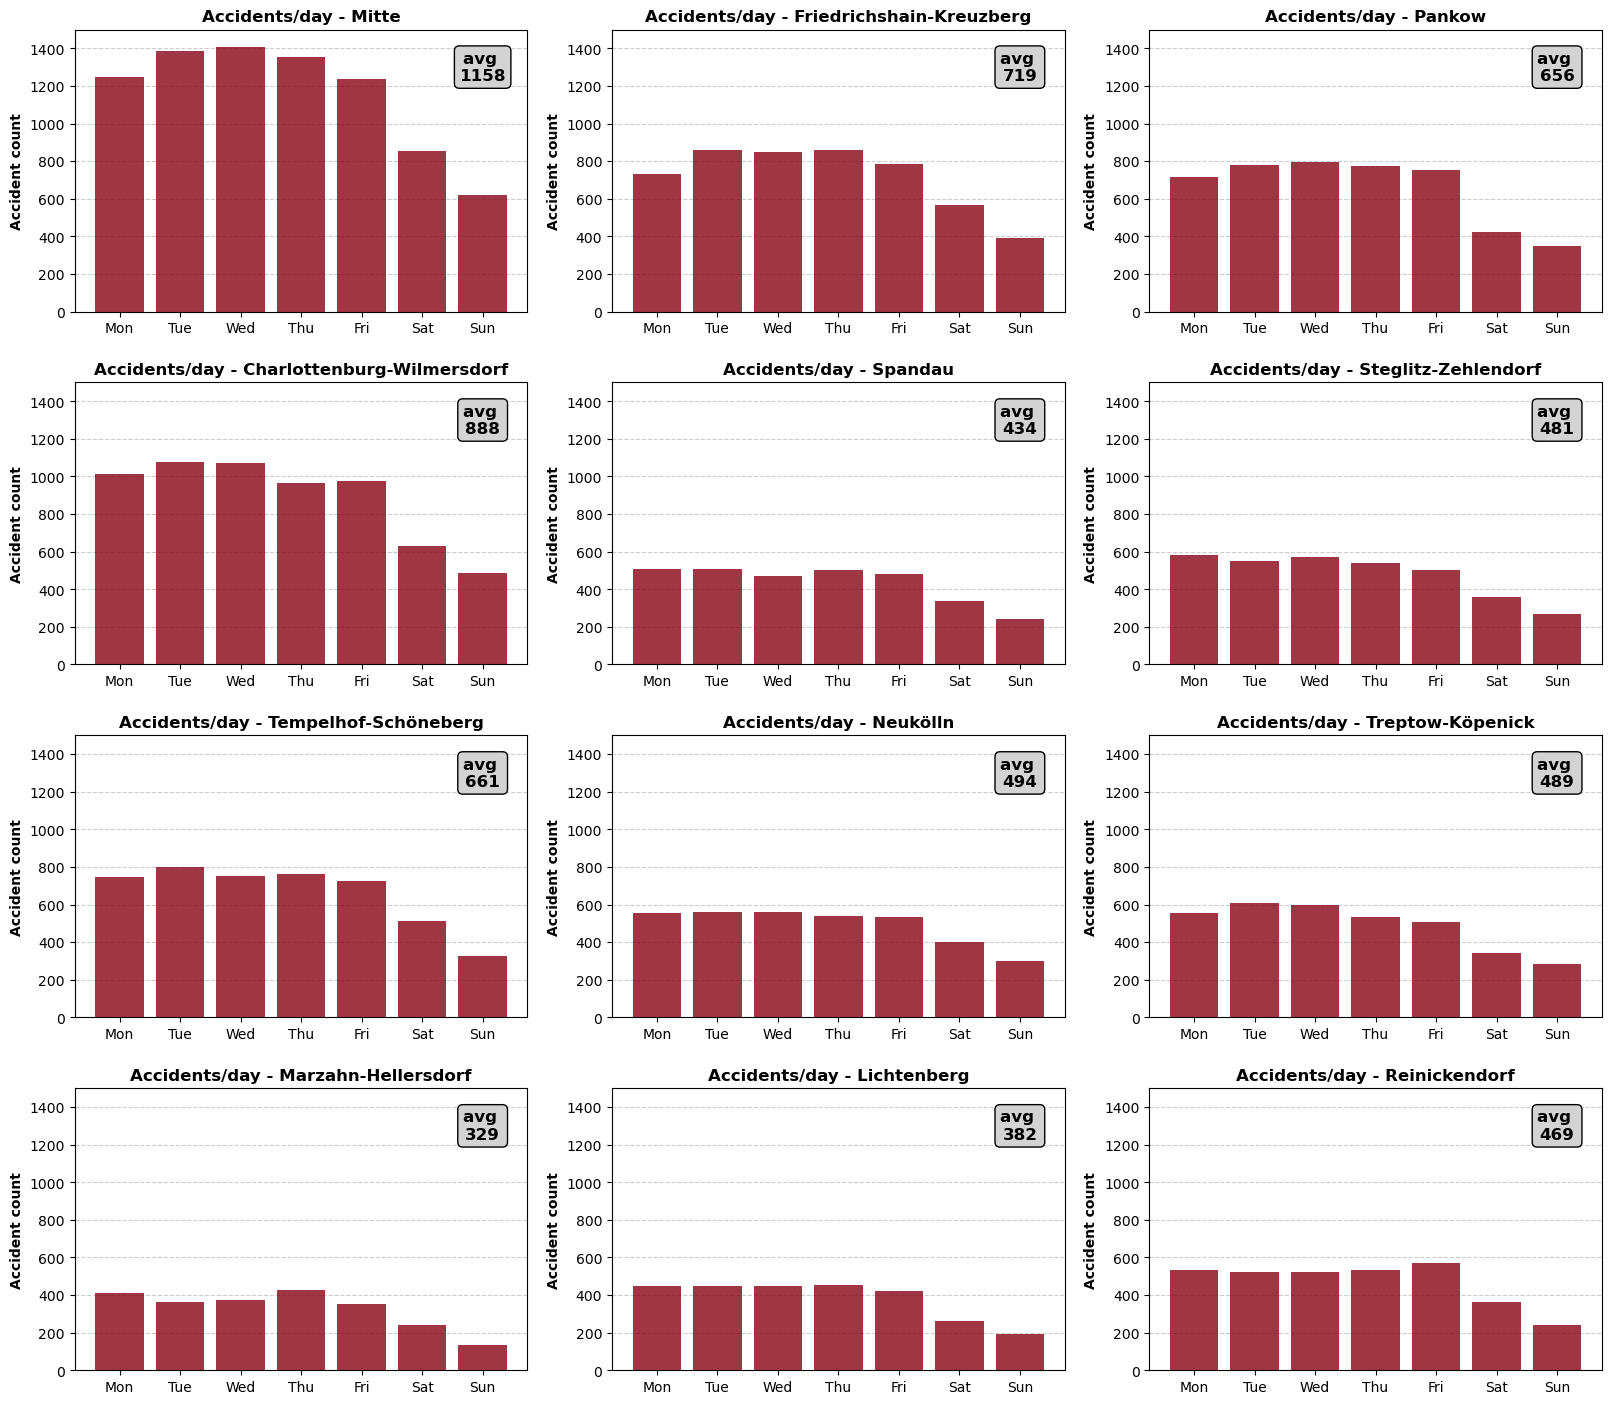

In [83]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

### PLOT CUMMULATIVE ACCIDENTS (TOTAL) PER DAY PER BOROUGH ###
fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3, w_pad = 3)

for p in range(rows*cols):
    df_borough = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df_borough[df_borough["uwochentag"]==day]) for day in weekdays_num]
    accs_weekday_avg = int(round(np.mean(accidents_per_weekday),0))

    ax[plot_coords[p]].set_title(f"Accidents/day - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--", axis="y")
    ax[plot_coords[p]].bar(weekdays_num, accidents_per_weekday, zorder=3, color="#860315", alpha=0.8)
    ax[plot_coords[p]].set_xticks(weekdays_num, weekdays)
    ax[plot_coords[p]].set_ylim([0,1500])
    ax[plot_coords[p]].set_ylabel("Accident count", weight="bold")
    ax[plot_coords[p]].annotate("avg \n" + str(accs_weekday_avg), (7, 1300), 
                                weight="bold", ha="center", va="center", size=12,
                                bbox=dict(boxstyle="round", fc="lightgrey"), zorder=5)

plt.show()

set monday as 100% and normalize following days

### Accidents per day and borough normalized

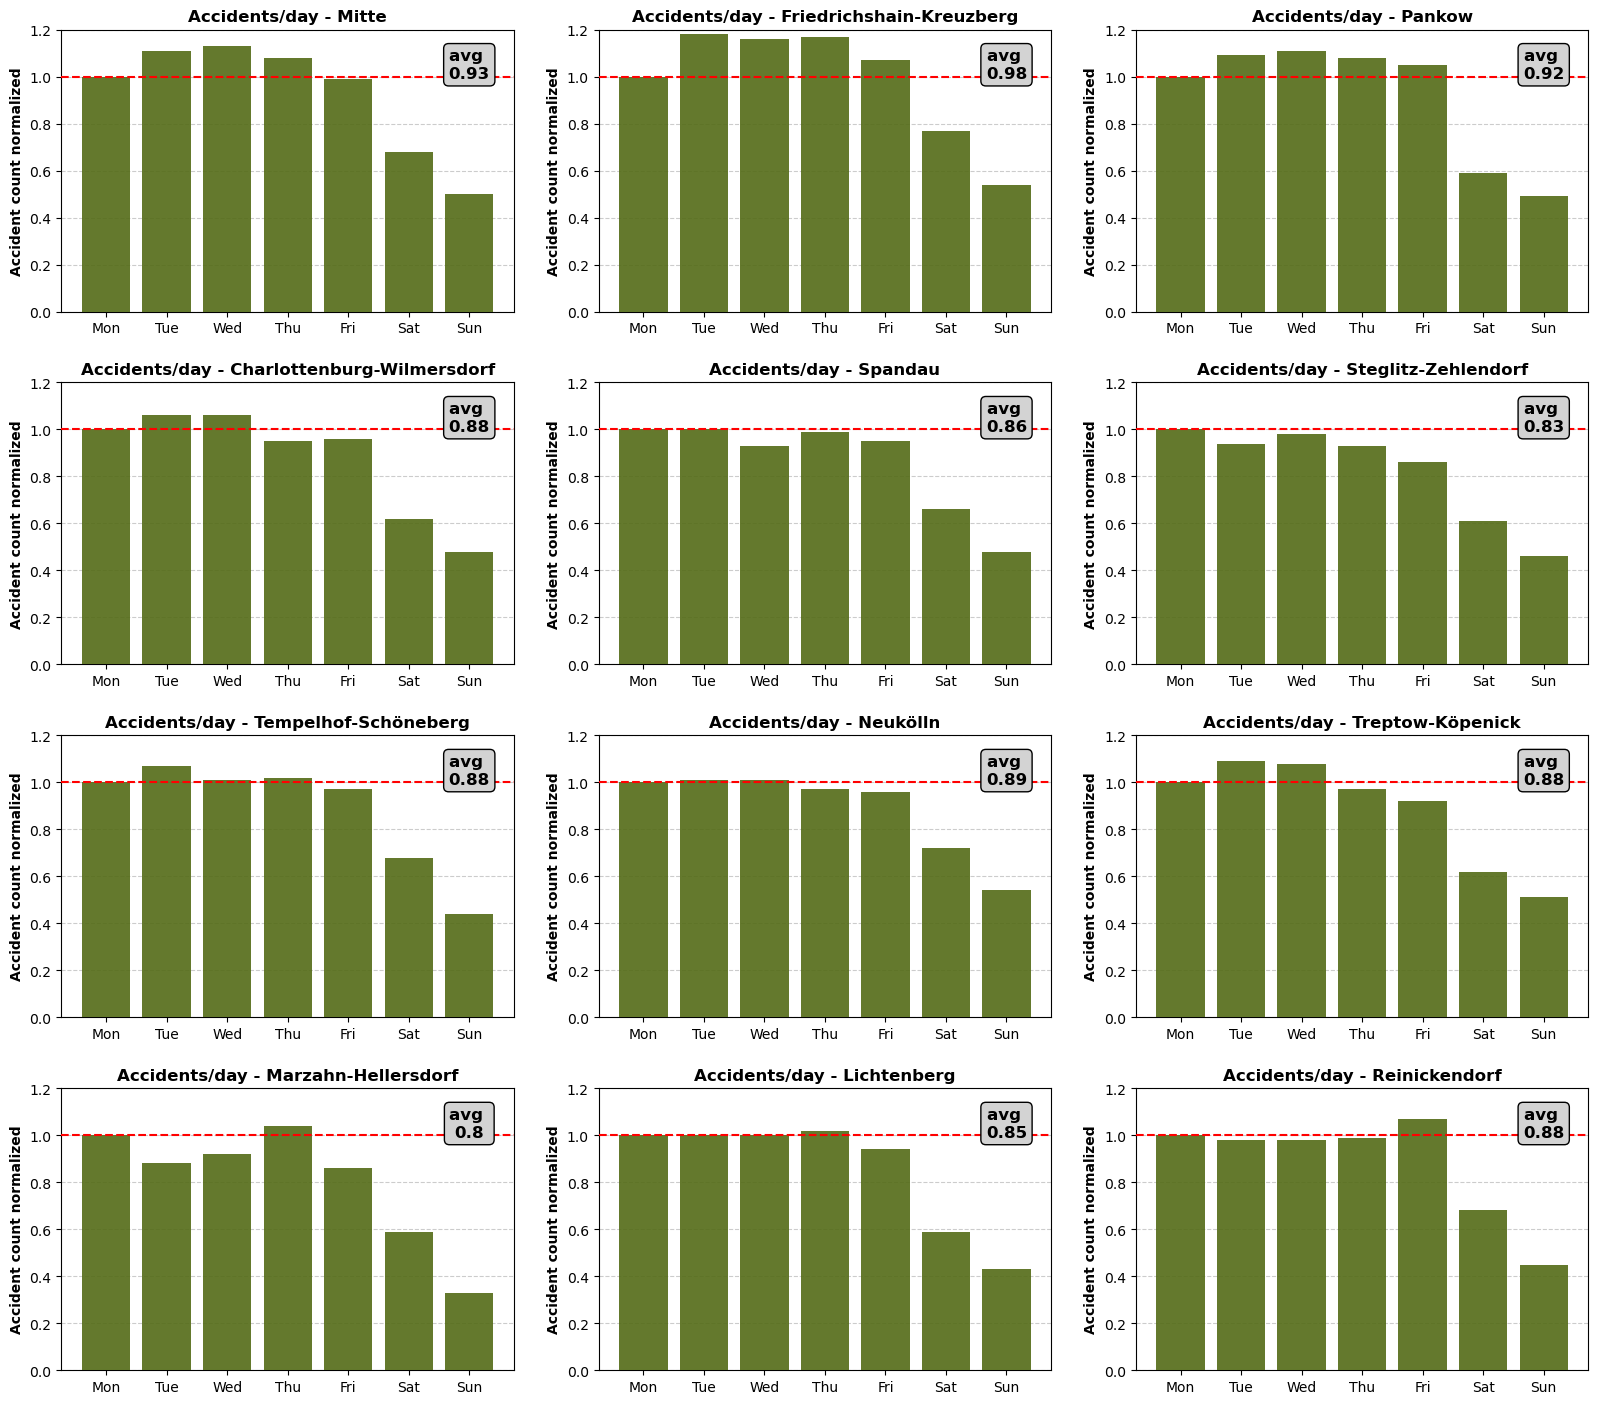

In [84]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

### PLOT CUMMULATIVE ACCIDENTS (RELATIVE; NORMALIZED ON MONDAYs) PER DAY PER BOROUGH ###
fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3, w_pad = 3)

for p in range(rows*cols):
    # Customer Lifetime Value
    
    df_borough = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df_borough[df_borough["uwochentag"]==day]) for day in weekdays_num]
    accidents_per_weekday_norm = [round(num/accidents_per_weekday[0],2) for num in accidents_per_weekday]
    accs_norm_avg = round(np.mean(accidents_per_weekday_norm),2)

    ax[plot_coords[p]].set_title(f"Accidents/day - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--", axis="y")
    ax[plot_coords[p]].bar(weekdays_num, accidents_per_weekday_norm, zorder=3, color="#536b16", alpha=0.9)
    ax[plot_coords[p]].axhline(y=1, color='red', linestyle='--', zorder=4)
    ax[plot_coords[p]].set_xticks(weekdays_num, weekdays)
    ax[plot_coords[p]].set_ylim([0,1.2])
    ax[plot_coords[p]].set_ylabel("Accident count normalized", weight="bold")
    ax[plot_coords[p]].annotate("avg \n" + str(accs_norm_avg), (7, 1.05), 
                                weight="bold", ha="center", va="center", size=12,
                                bbox=dict(boxstyle="round", fc="lightgrey"), zorder=5)

plt.show()



### Overall Monday-normalized accident counts

In [73]:
accidents_per_weekday_summed = [0]*len(accidents_per_weekday_norm)

for p in range(rows*cols):
    df = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df[df["uwochentag"]==day]) for day in weekdays_num]
    accidents_per_weekday_norm = [round(num/accidents_per_weekday[0],2) for num in accidents_per_weekday]
    
    for idx,_ in enumerate(accidents_per_weekday_norm):
        accidents_per_weekday_summed[idx] += accidents_per_weekday_norm[idx]
        
accidents_per_weekday_summed_norm = [round((num/accidents_per_weekday_summed[0])-1,3) 
                                     for num in accidents_per_weekday_summed]
accidents_per_weekday_summed_norm_str = [str(round(i*100,1))+" %" for i in accidents_per_weekday_summed_norm]
accidents_per_weekday_summed_norm_str

['0.0 %', '3.4 %', '3.1 %', '1.8 %', '-3.3 %', '-34.9 %', '-52.9 %']

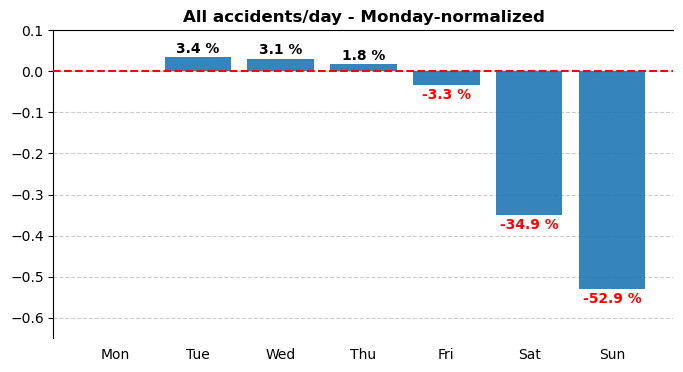

In [74]:
### PLOTTING ###
# GENERAL
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title(f"All accidents/day - Monday-normalized", size=12, weight="bold")
#ax.grid(color="k", alpha=0.8, ls="-", axis="x")
ax.grid(color="k", alpha=0.2, ls="--", axis="y")

# PLOTTING DATA
x = weekdays_num
y = accidents_per_weekday_summed_norm

# PLOT
ax.bar(x, y, zorder=3, alpha=0.9) #, color="#536b16"
ax.axhline(y=0, color='red', linestyle='--', zorder=4)

# AXIS HANDLING
ax.set_xticks(weekdays_num, weekdays)
ax.set_ylim([-0.65, 0.1])

#ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.tick_params(axis="x", bottom=False)

# ANNOTATIONS
strings = accidents_per_weekday_summed_norm_str
y_positions = accidents_per_weekday_summed_norm
x_positions = weekdays_num
anot_colors = ["k", "k", "k", "k", "r", "r", "r"]
for i in range(len(x_positions)):
    if i == 0:
        pass
    elif y_positions[i] > 0:
        spacer = 0.02
        ax.annotate(strings[i], (x_positions[i], y_positions[i]+spacer), 
                    ha="center", va="center", weight="bold", color=anot_colors[i])
    else:
        spacer = -0.025
        ax.annotate(strings[i], (x_positions[i], y_positions[i]+spacer), 
                    ha="center", va="center", weight="bold", color=anot_colors[i])

# SAVE FIG
#plt.savefig("all_accidents_per_day_monday_normalized.jpg", dpi=300, bbox_inches="tight")

plt.show()

**`OBSERVATIONS`**

- Monday is not the day with most accidents!
- on Tuesdays happen the most accidents on an overall averaged basis (+3.4% compared to Monday)
- closely behind is Wednesday with +3.1%
- on weekends substantially fewer accidents happen
    - most likely due to significantly less traffic
- maybe being able to rest on the weekend people are a tiny bit less likely to be involved / cause accidents on Mondays?

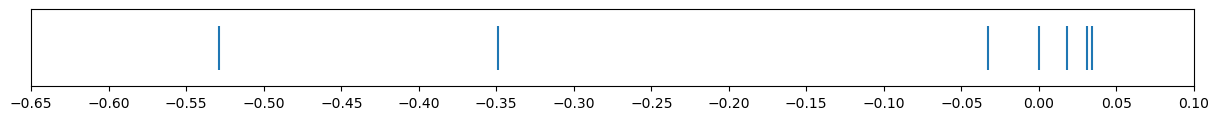

In [75]:
x = accidents_per_weekday_summed_norm
y = [1]*len(accidents_per_weekday_summed_norm)

fig, ax = plt.subplots(figsize=(15,1))
plt.scatter(x,y, marker="|", s=1000)
ax.get_yaxis().set_visible(False) # set y-axis to invisible
ax.set_xticks(np.arange(-0.65, 0.11, 0.05))

plt.show()

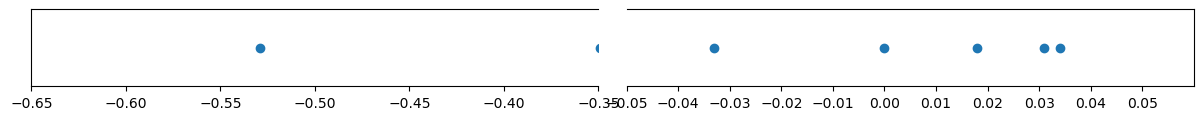

In [76]:
### PLOT WITH BROKEN X-AXIS ###

f,(ax,ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,1))
f.subplots_adjust(wspace=0.05)

# plot the same data on both axes
ax.scatter(x, y)
ax2.scatter(x, y)

ax.set_xlim(-0.65, -0.35)
ax.set_xticks(np.arange(-0.65, -0.35, 0.05))
ax2.set_xlim(-0.05, 0.06)
ax2.set_xticks(np.arange(-0.05, 0.06, 0.01))

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.yaxis.tick_right()
ax.get_yaxis().set_visible(False) # set y-axis to invisible
ax2.get_yaxis().set_visible(False) # set y-axis to invisible

plt.show()

## More accidents on rainy/slippery days?

### Split df into data for dry, wet, slippery

In [77]:
#0 = trocken // dry
#1 = nass/feucht/schlüpfrig // wet/damp/slippery
#2 = winterglatt // winter slipperiness

data21["ustrzustand"].value_counts().sort_index()

0    8407
1    2694
2     166
Name: ustrzustand, dtype: int64

In [78]:
data_all_dry = data_all[data_all["ustrzustand"]==0].reset_index(drop=True)
data_all_wet = data_all[data_all["ustrzustand"]==1].reset_index(drop=True)
data_all_slippery = data_all[data_all["ustrzustand"]==2].reset_index(drop=True)

len(data_all_dry), len(data_all_wet), len(data_all_slippery)

(38670, 11152, 296)

### Rain / ice days per year data

[weather data berlin 2018-2020](https://www.weatheronline.de/weather/maps/city?LANG=de&PLZ=_____&PLZN=_____&WMO=10384&CONT=dldl&R=0&LEVEL=162&REGION=0001&LAND=DL&MOD=tab&ART=EIT&NOREGION=0)

In [79]:
# Data for weather station in Berlin-Tempelhof is used representatively
# as I found no data generalized for all Berlin

# days with precipitation > 0.1mm
rainy_days_per_year = [[2018, 75], [2019, 108], [2020, 86], [2021, 177]]
rainy_days_per_year_median = np.median([tup[1] for tup in rainy_days_per_year])
rainy_days_per_year_mean = np.mean([tup[1] for tup in rainy_days_per_year])

# Ice days are the days of the year when both the nighttime minimum temperature 
# and the daytime maximum temperature are below 0°C.
# Recorded icey days have been multiplied by two to account for snowy days 
# in a rather crude way as data was very lackluster for snowy days.
slippery_days_per_year = [[2018, 10*2], [2019, 4*2], [2020, 1*2], [2021, 15*2]]
slippery_days_per_year_median = np.median([tup[1] for tup in slippery_days_per_year])
slippery_days_per_year_mean = np.mean([tup[1] for tup in slippery_days_per_year])

# Define dry days as the difference between total number of years (=365, except for 2020 with 366 as leap year)
# and rainy & icey days
dry_days_per_year = [[2018, 365-10-75], [2019, 365-4-108], [2020, 366-1-86], [2021, 365-15-177]]
dry_days_per_year_median = np.median([tup[1] for tup in dry_days_per_year])
dry_days_per_year_mean = np.mean([tup[1] for tup in dry_days_per_year])


### Accidents per year with varying conditions (dry / wet / icey)

In [80]:
days_per_year_wet = [[2018, 75], [2019, 108], [2020, 86], [2021, 177]]
days_per_year_slippery = [[2018, 20], [2019, 8], [2020, 2], [2021, 30]]
days_per_year_dry = [[2018, 280], [2019, 253], [2020, 279], [2021, 173]]

for idx, year in enumerate([tup[0] for tup in rainy_days_per_year]):
    
    #if year = 2020:
        #daysinyear = 366
    #else:
        #daysinyear = 365
    
    wet = data_all_wet[data_all_wet["ujahr"]==year]
    days_per_year_wet[idx].append(len(wet))
    days_per_year_wet[idx].append(round(len(wet) / days_per_year_wet[idx][1],1))
    
    slippery = data_all_slippery[data_all_slippery["ujahr"]==year]
    days_per_year_slippery[idx].append(len(slippery))
    days_per_year_slippery[idx].append(round(len(slippery) / days_per_year_slippery[idx][1],1))
    
    dry = data_all_dry[data_all_dry["ujahr"]==year]
    days_per_year_dry[idx].append(len(dry))
    days_per_year_dry[idx].append(round(len(dry) / days_per_year_dry[idx][1],1))
    
print("<<< WET DAYS >>>")
print(f"2018 - {days_per_year_wet[0][1]} days - {days_per_year_wet[0][2]} accidents - {days_per_year_wet[0][3]} accidents/day")
print(f"2019 - {days_per_year_wet[1][1]} days - {days_per_year_wet[1][2]} accidents - {days_per_year_wet[1][3]} accidents/day")
print(f"2020 - {days_per_year_wet[2][1]} days - {days_per_year_wet[2][2]} accidents - {days_per_year_wet[2][3]} accidents/day")
print(f"2021 - {days_per_year_wet[3][1]} days - {days_per_year_wet[3][2]} accidents - {days_per_year_wet[3][3]} accidents/day")
print()
print("<<< SLIPPERY DAYS >>>")
print(f"2018 - {days_per_year_slippery[0][1]} days - {days_per_year_slippery[0][2]} accidents - {days_per_year_slippery[0][3]} accidents/day")
print(f"2019 - {days_per_year_slippery[1][1]} days - {days_per_year_slippery[1][2]} accidents - {days_per_year_slippery[1][3]} accidents/day")
print(f"2020 - {days_per_year_slippery[2][1]} days - {days_per_year_slippery[2][2]} accidents - {days_per_year_slippery[2][3]} accidents/day")
print(f"2021 - {days_per_year_slippery[3][1]} days - {days_per_year_slippery[3][2]} accidents - {days_per_year_slippery[3][3]} accidents/day")
print()
print("<<< DRY DAYS >>>")
print(f"2018 - {days_per_year_dry[0][1]} days - {days_per_year_dry[0][2]} accidents - {days_per_year_dry[0][3]} accidents/day")
print(f"2019 - {days_per_year_dry[1][1]} days - {days_per_year_dry[1][2]} accidents - {days_per_year_dry[1][3]} accidents/day")
print(f"2020 - {days_per_year_dry[2][1]} days - {days_per_year_dry[2][2]} accidents - {days_per_year_dry[2][3]} accidents/day")
print(f"2021 - {days_per_year_dry[3][1]} days - {days_per_year_dry[3][2]} accidents - {days_per_year_dry[3][3]} accidents/day")

<<< WET DAYS >>>
2018 - 75 days - 2540 accidents - 33.9 accidents/day
2019 - 108 days - 3190 accidents - 29.5 accidents/day
2020 - 86 days - 2728 accidents - 31.7 accidents/day
2021 - 177 days - 2694 accidents - 15.2 accidents/day

<<< SLIPPERY DAYS >>>
2018 - 20 days - 64 accidents - 3.2 accidents/day
2019 - 8 days - 45 accidents - 5.6 accidents/day
2020 - 2 days - 21 accidents - 10.5 accidents/day
2021 - 30 days - 166 accidents - 5.5 accidents/day

<<< DRY DAYS >>>
2018 - 280 days - 11048 accidents - 39.5 accidents/day
2019 - 253 days - 10154 accidents - 40.1 accidents/day
2020 - 279 days - 9061 accidents - 32.5 accidents/day
2021 - 173 days - 8407 accidents - 48.6 accidents/day


**`OBSERVATIONS`**

- wet (rainy) and slippery (icey, snowy) days don't show more accidents / per than dry
- likely due to less traffic (cars, bikes, humans, etc.) during bad weather

## Check accident counts vs borough population

[Berlin population per borough 2019 representation](https://www.citypopulation.de/de/germany/berlin/admin/)

- 2019 selected as representative year from population standpoint as found differences to 2020 or 2021 are small and data for these last two years is more difficult to find

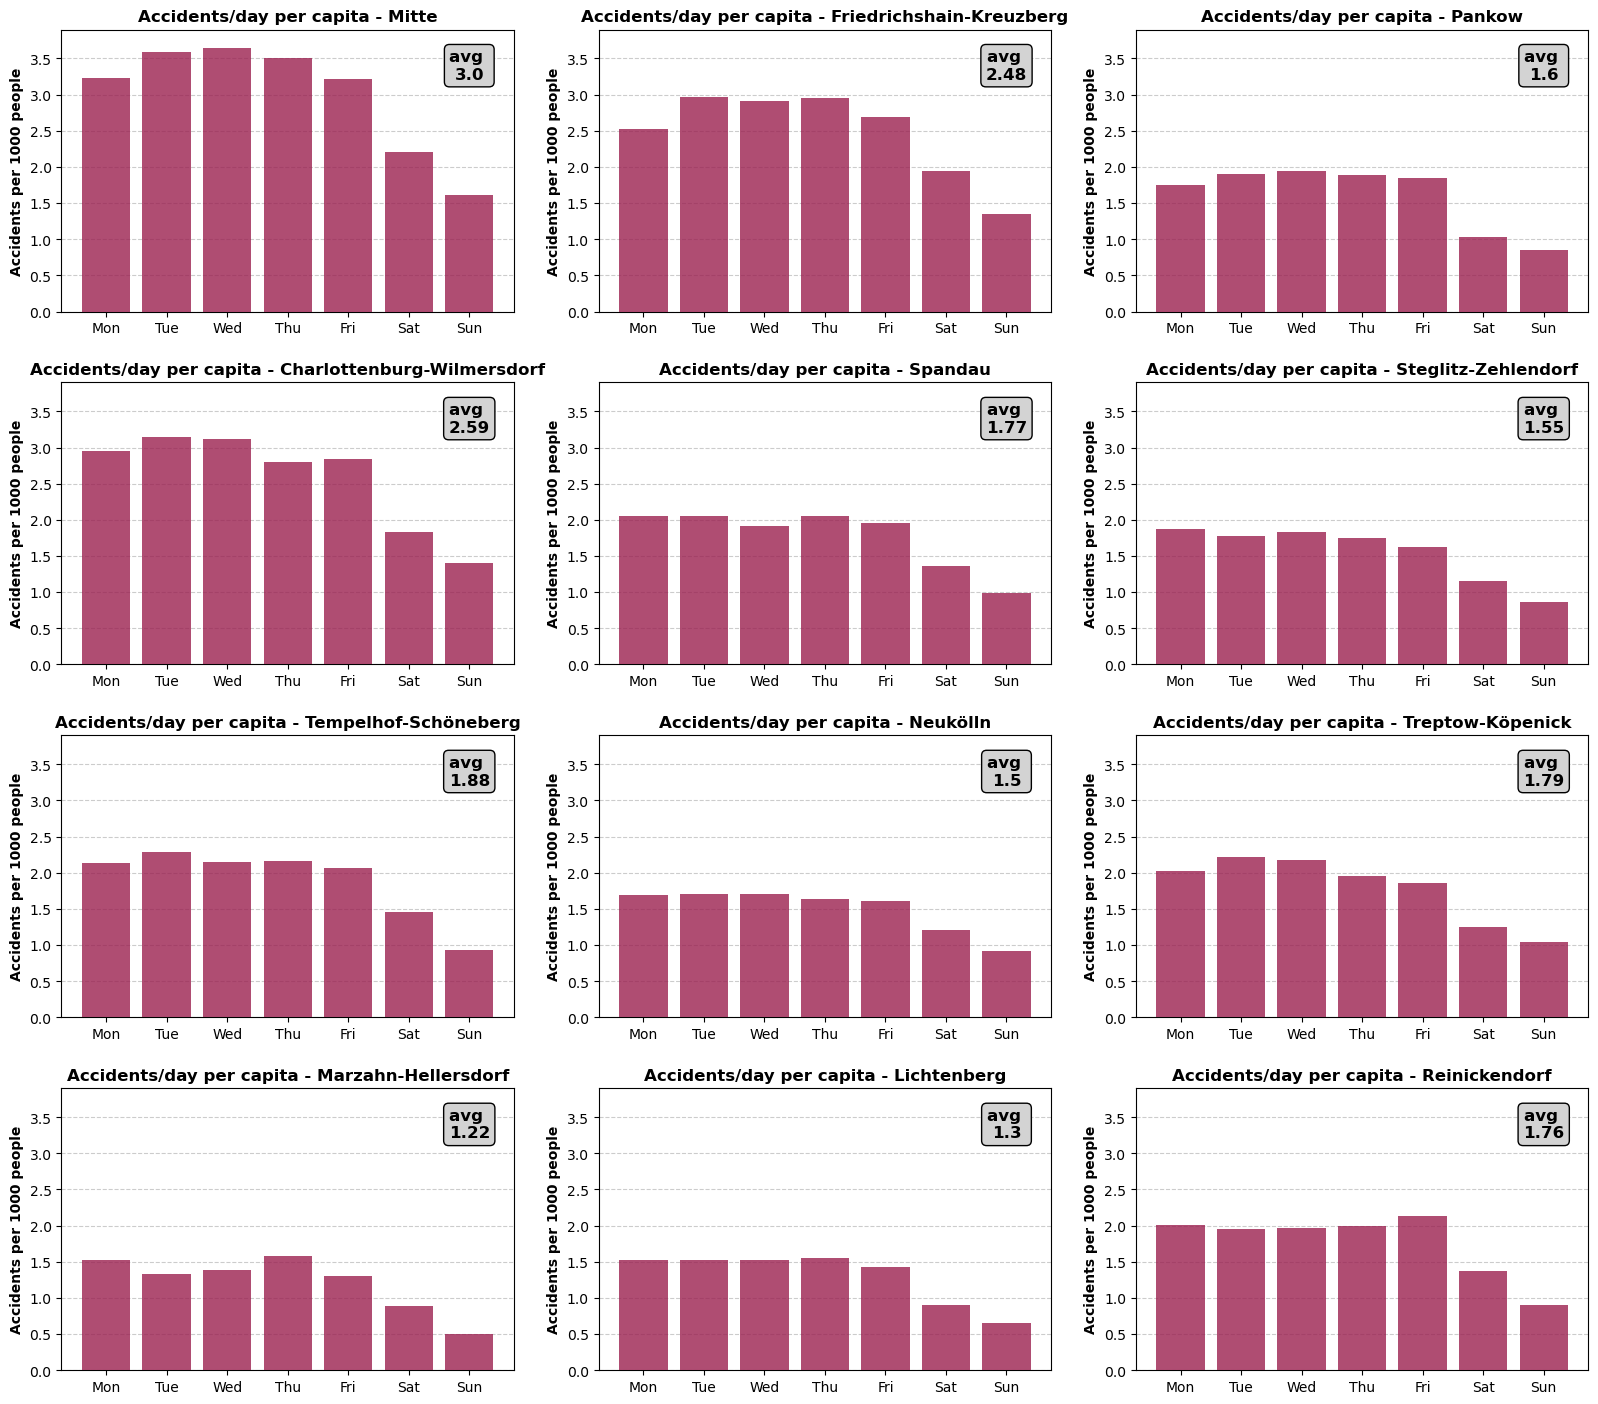

In [85]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

borough_pop_2019 = [385748, 290386, 409335, 343592, 
                    245197, 310071, 350984, 329917, 
                    273689, 269967, 294201, 266408]

### PLOT CUMMULATIVE ACCIDENTS (TOTAL) PER DAY PER BOROUGH PER CAPITA ###
fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3, w_pad = 3)

for p in range(rows*cols):
    df_borough = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df_borough[df_borough["uwochentag"]==day]) for day in weekdays_num]
    accidents_per_weekday_perCapita = [(acc/borough_pop_2019[p])*1000 for acc in accidents_per_weekday]
    perCapita_avg = round(np.mean(accidents_per_weekday_perCapita),2)
    
    ax[plot_coords[p]].set_title(f"Accidents/day per capita - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--", axis="y")
    ax[plot_coords[p]].bar(weekdays_num, accidents_per_weekday_perCapita, zorder=3, color="#9b204f", alpha=0.8)
    ax[plot_coords[p]].set_xticks(weekdays_num, weekdays)
    ax[plot_coords[p]].set_ylim([0,3.9])
    ax[plot_coords[p]].set_ylabel("Accidents per 1000 people", weight="bold")
    ax[plot_coords[p]].annotate("avg \n" + str(perCapita_avg), (7, 3.4), 
                                weight="bold", ha="center", va="center", size=12,
                                bbox=dict(boxstyle="round", fc="lightgrey"))

plt.show()

**`OBSERVATIONS`**

- most dangerous borough is Mitte with an average of 3.0 accidents/der per 1000 inhabitants
- least dangerous borough is Marzahn-Hellersdorf with an average of 1.22 accidents/der per 1000 inhabitants